## Feature Selection for Multiclass Classification (12 target variables)

The aim of this notebook is to perform feature selection using multiclass classification for DDoS attack detection. The feature selection technique that is implemented:

1. Random Forest
2. Brute Force

In [ ]:
import pandas as pd
import numpy as np
import random # seed
from sklearn.utils import resample
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import os

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split


# modules to interpret the training result
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

# silent the warning
import warnings
warnings.filterwarnings('ignore')

# ensure reproducibility
random.seed(10)
np.random.seed(10)


In [ ]:
# load the encoded multiclass file

CICDDoS2019_multi = pd.read_csv(r'Dataset/Encoded Dataset/CIC-DDoS2019_multi.csv')
CICDDoS2019_multi = CICDDoS2019_multi.sample(frac=0.1).reset_index(drop=True)
CICDDoS2019_multi.shape

(30000, 79)

In [ ]:
# to separate the features and target variables

CICDDoS2019_multi_X = CICDDoS2019_multi.drop(CICDDoS2019_multi.filter(regex='^Label_'), axis=1).copy()
CICDDoS2019_multi_y = CICDDoS2019_multi[CICDDoS2019_multi.filter(regex='^Label_').columns].copy()


In [ ]:
#normalisation

X_columns = CICDDoS2019_multi_X.columns
CICDDoS2019_multi_X = StandardScaler().fit_transform(CICDDoS2019_multi_X)

### To perform Random Forest 

In [ ]:
%%time

rfc = RandomForestClassifier()
rfc.fit(CICDDoS2019_multi_X, CICDDoS2019_multi_y)

CPU times: total: 11.9 s
Wall time: 11.9 s


RandomForestClassifier()

This section listed the top 30 ranked features according to their feature importance score

Top features: 
                             importance score
feature                                      
Avg Fwd Segment Size                    0.073
Min Packet Length                       0.063
Fwd Packet Length Max                   0.061
Fwd Packet Length Mean                  0.059
Average Packet Size                     0.056
Packet Length Mean                      0.056
Max Packet Length                       0.052
Fwd Packet Length Min                   0.048
Total Length of Fwd Packets             0.044
Subflow Fwd Bytes                       0.030
Flow Bytes/s                            0.028
ACK Flag Count                          0.027
Fwd IAT Total                           0.027
Fwd IAT Std                             0.027
Flow IAT Mean                           0.026
Fwd IAT Mean                            0.025
act_data_pkt_fwd                        0.025
Flow IAT Std                            0.024
Flow Duration                           0.023
Init_Win_bytes_forw

<Axes: xlabel='feature'>

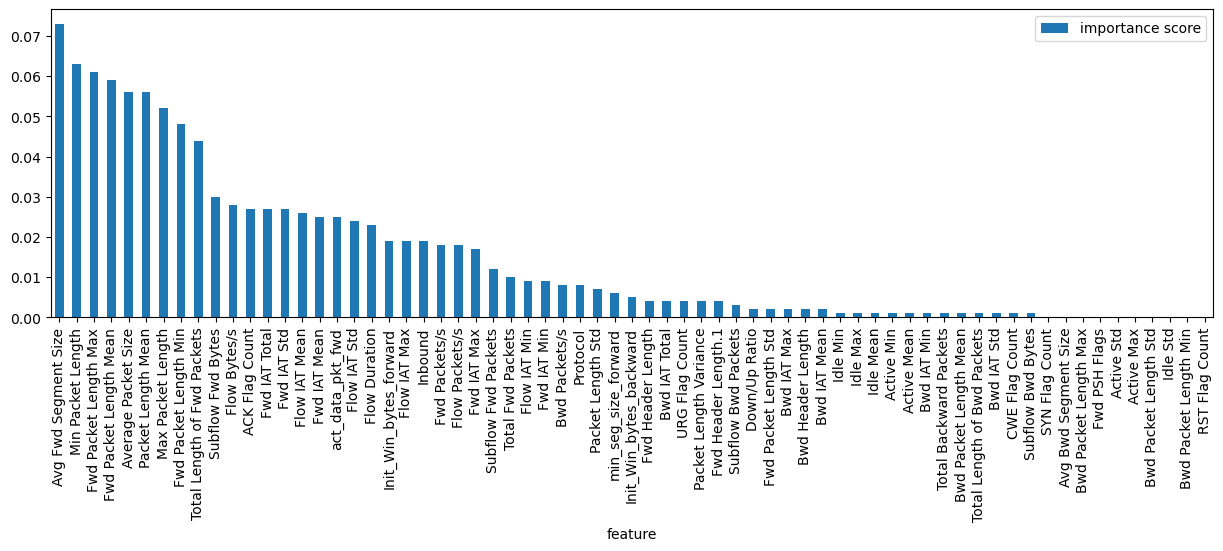

In [ ]:
#extract the importance score
score = np.round(rfc.feature_importances_, 3)
importance = pd.DataFrame({'feature': X_columns,
                             'importance score': score})
importance = importance.sort_values('importance score', ascending=False).set_index('feature')

print(f"Top features: \n{importance[:30]}")

plt.rcParams['figure.figsize'] = (15, 4)
importance.plot.bar()

#### To create a directory and save the selected features  

In [ ]:
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):

    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag

    directory = 'Dataset/Feature selected'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"

    # create directory to save the file
    os.makedirs(directory, exist_ok=True)

    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"The features have been saved in {directory}/{file_name}.csv")

In [ ]:
# save the ranking of the features in a CSV file
features = pd.Series(importance.index[:30], dtype='str')
save_feature(features=features,
            dataset_name='CICDDoS2019_Multiclass',
            algorithm='RFClassifier')

The features have been saved in Dataset/Feature selected/CICDDoS2019_Multiclass_RFClassifier_30.csv


Use only the selected top 30 ranked features + 12 target variables

In [ ]:
columns = features.tolist() + [col for col in CICDDoS2019_multi.columns if col.startswith('Label_')]
CICDDoS2019_multi = CICDDoS2019_multi[columns]
CICDDoS2019_multi.shape

(30000, 42)

In [ ]:

#separate features and all target column with prefixed name
CICDDoS2019_multi_X = CICDDoS2019_multi.drop(CICDDoS2019_multi.filter(regex='^Label_'), axis=1).copy()
CICDDoS2019_multi_y = CICDDoS2019_multi[CICDDoS2019_multi.filter(regex='^Label_').columns].copy()


DDoS2019_multi_train_X, DDoS2019_multi_test_X, DDoS2019_multi_train_y, DDoS2019_multi_test_y = train_test_split(CICDDoS2019_multi_X, CICDDoS2019_multi_y, stratify=CICDDoS2019_multi_y, test_size=0.3)


In [ ]:

# build ML models without optimized hyperparameter

models = {
    'K-Nearest Neighbour': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(40), max_iter=500),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(12, 12, 12), max_iter=500),
    'XGBoost': xgb.XGBClassifier()
}


# Brute Force

The top 30 features are further reduced using Brute Force algorithm

In [ ]:
%%time

feature_set = []
scaler = StandardScaler()
scores = []

for feature in features:
    feature_set.append(feature)
    print(f"Added feature {len(feature_set)} ({feature})...")

    train_X = DDoS2019_multi_train_X[feature_set]
    test_X = DDoS2019_multi_test_X[feature_set]

    # Scale the dataset
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    score_temp = [len(feature_set)]

    for model in models:
        clf = models[model]
        clf.fit(train_X_scaled, DDoS2019_multi_train_y.to_numpy().argmax(axis=1))  # Convert y to 1D array

        prediction = clf.predict(test_X_scaled)
        accuracy = metrics.accuracy_score(DDoS2019_multi_test_y.to_numpy().argmax(axis=1), prediction)  # Convert y to 1D array

        score_temp.append(accuracy)

    scores.append(score_temp)

scores = np.array(scores)


Added feature 1 (Avg Fwd Segment Size)...
Added feature 2 (Min Packet Length)...
Added feature 3 (Fwd Packet Length Max)...
Added feature 4 (Fwd Packet Length Mean)...
Added feature 5 (Average Packet Size)...
Added feature 6 (Packet Length Mean)...
Added feature 7 (Max Packet Length)...
Added feature 8 (Fwd Packet Length Min)...
Added feature 9 (Total Length of Fwd Packets)...
Added feature 10 (Subflow Fwd Bytes)...
Added feature 11 (Flow Bytes/s)...
Added feature 12 (ACK Flag Count)...
Added feature 13 (Fwd IAT Total)...
Added feature 14 (Fwd IAT Std)...
Added feature 15 (Flow IAT Mean)...
Added feature 16 (Fwd IAT Mean)...
Added feature 17 (act_data_pkt_fwd)...
Added feature 18 (Flow IAT Std)...
Added feature 19 (Flow Duration)...
Added feature 20 (Init_Win_bytes_forward)...
Added feature 21 (Flow IAT Max)...
Added feature 22 (Inbound)...
Added feature 23 (Fwd Packets/s)...
Added feature 24 (Flow Packets/s)...
Added feature 25 (Fwd IAT Max)...
Added feature 26 (Subflow Fwd Packets)..

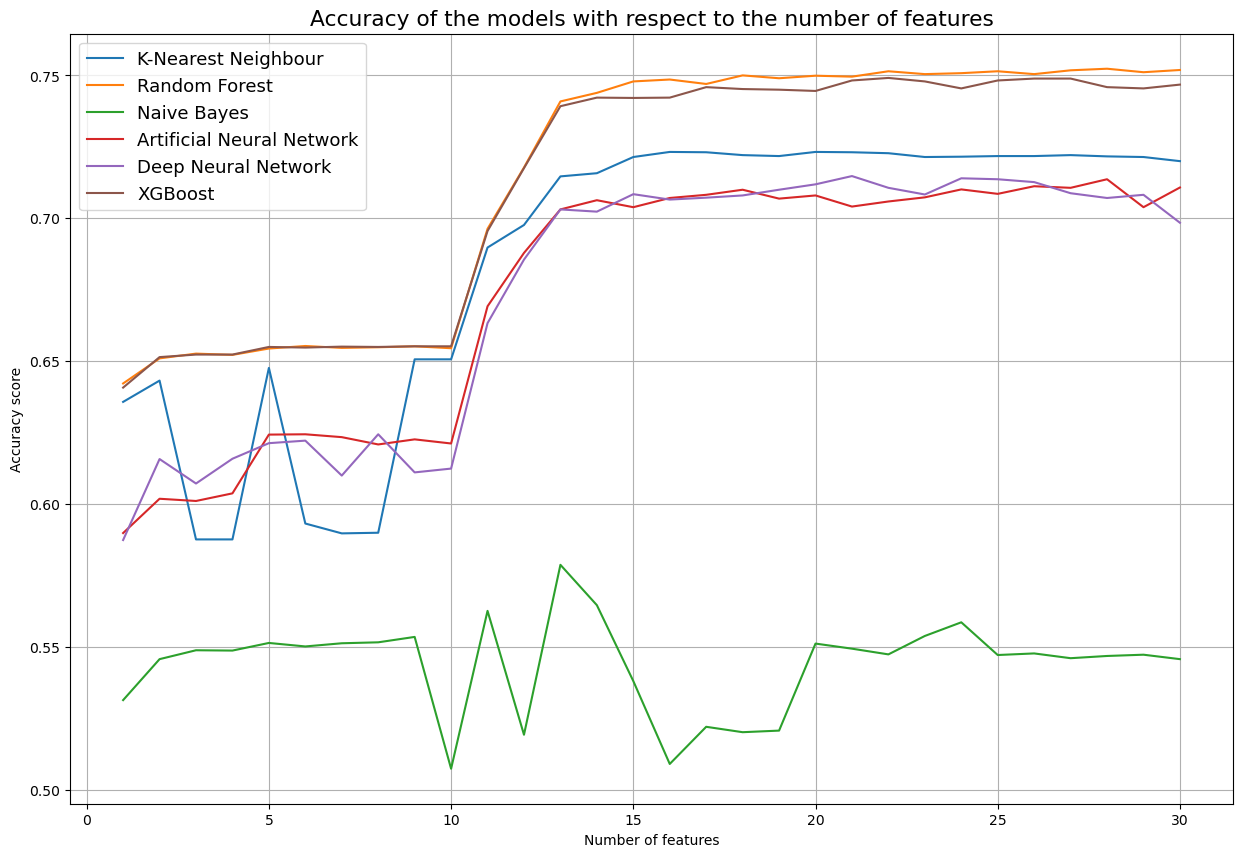

In [ ]:
#visualise the result

plt.figure(figsize=(15, 10))
for index, model in enumerate(models):
    plt.plot(scores.T[0], scores.T[index + 1], label=model)

plt.rcParams.update({'font.size': 13})
plt.title('Accuracy of the models with respect to the number of features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy score')
plt.legend()
plt.grid()
plt.show()